In [121]:
import os
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Lambda,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR, DenseNet121

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    Dataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    DataLoader,
)
from monai.data.utils import list_data_collate

import torch
import os

os.environ["KERAS_BACKEND"] = "torch"

from keras.layers import TorchModuleWrapper
import keras
from functools import partial
from keras.src.backend.torch.core import get_device
from keras.src.trainers.data_adapters import data_adapter_utils


In [2]:
# get this to work!
# keras.mixed_precision.set_global_policy("mixed_float16")


In [119]:
def dict_to_tuple(data):
    return data["image"], data["label"]

In [122]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"], channel_dim=float("nan")),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
        Lambda(lambda d: (d["image"], d["label"])),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"], channel_dim=float("nan")),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
        Lambda(lambda d: (d["image"], d["label"])),
    ]
)

In [4]:
from pathlib import Path

image_root = Path("RawData/Training/img")
label_root = Path("RawData/Training/label")
files = [
    {"image": i.as_posix(), "label": (label_root / i.name.replace("img", "label")).as_posix()}
    for i in image_root.glob("*.nii.gz")
]

val_names = [
    "img0035.nii.gz",
    "img0036.nii.gz",
    "img0037.nii.gz",
    "img0038.nii.gz",
    "img0039.nii.gz",
    "img0040.nii.gz",
]

val_files = [i for i in files if i["image"].split("/")[-1] in val_names]
train_files = [i for i in files if i["image"].split("/")[-1] not in val_names]
assert len(val_files) + len(train_files) == len(files)

In [128]:
train_ds = CacheDataset(
    data=train_files,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# set_track_meta(False)


Loading dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


In [7]:
# train_ds = Dataset(data=train_files, transform=train_transforms)
# train_loader = torch.utils.data.DataLoader(
#     train_ds, num_workers=16, batch_size=2, shuffle=True, pin_memory=True, collate_fn=collate_fn
# )
# val_ds = Dataset(data=val_files, transform=val_transforms)
# val_loader = torch.utils.data.DataLoader(val_ds, num_workers=16, batch_size=1, pin_memory=True, collate_fn=collate_fn)

In [129]:
class CustomTorchWrapper(keras.layers.TorchModuleWrapper):
    def compute_output_spec(self, inputs_spec, output_channels=14):
        channels = output_channels
        h, w, d = inputs_spec.shape[2:]
        output_shape = (None, channels, h, w, d)
        return keras.KerasTensor(shape=output_shape, dtype="float32")


class SlidingWindowValidationModel(keras.models.Model):
    def test_step(self, data):
        x, y, sample_weight = data_adapter_utils.unpack_x_y_sample_weight(data)

        y_pred = sliding_window_inference(x.to(get_device()), (96, 96, 96), 4, partial(self, training=False))
        return self.compute_metrics(x, y, y_pred, sample_weight)


model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=14,
    feature_size=48,
    use_checkpoint=True,
)
inputs = keras.layers.Input(shape=(1, 96, 96, 96))
x = CustomTorchWrapper(model)(inputs)
k_model = SlidingWindowValidationModel(inputs, x)

/home/ubuntu/yonigo/ts_distill/.venv/lib/python3.13/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [130]:
class DiceCELossKeras(torch.nn.Module):
    def __init__(self, to_onehot_y, softmax, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l = DiceCELoss(to_onehot_y=to_onehot_y, softmax=softmax)

    def forward(self, y_true, y_pred):
        return self.l(y_pred, y_true)


class DiceMetricKeras(keras.metrics.Metric):
    def __init__(self, include_background=True, reduction="mean", get_not_nans=False, *args, **kwargs):
        super().__init__(name="monai_dice", *args, **kwargs)
        self.m = DiceMetric(include_background=include_background, reduction=reduction, get_not_nans=get_not_nans)

        self.post_label = AsDiscrete(to_onehot=14)
        self.post_pred = AsDiscrete(argmax=True, to_onehot=14)

    def reset_states(self):
        self.m.reset()

    def update_state(self, y_true, y_preds, sample_weight=None):
        y_true, y_preds = y_true.to("cpu"), y_preds.to("cpu")
        y_true_list = decollate_batch(y_true)
        y_true_convert = [self.post_label(val_label_tensor) for val_label_tensor in y_true_list]
        y_preds_list = decollate_batch(y_preds)
        y_preds_convert = [self.post_pred(val_pred_tensor) for val_pred_tensor in y_preds_list]

        self.m(y_pred=y_preds_convert, y=y_true_convert)

    def result(self):
        return self.m.aggregate().item()


In [131]:
k_model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4),
    loss=DiceCELossKeras(to_onehot_y=True, softmax=True),
    metrics=[DiceMetricKeras()],
    run_eagerly=False,
)

In [132]:
k_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=1000,
    validation_freq=10,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "model.weights.h5",
            save_weights_only=True,
            save_best_only=True,
            monitor="val_monai_dice",
            mode="max",
        )
    ],
)

Epoch 1/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 2.9417 - monai_dice: 0.1872
Epoch 2/1000


/home/ubuntu/yonigo/ts_distill/.venv/lib/python3.13/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_monai_dice available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 2.3053 - monai_dice: 0.2509
Epoch 3/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 2.1601 - monai_dice: 0.2700
Epoch 4/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 2.0822 - monai_dice: 0.2734
Epoch 5/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.9692 - monai_dice: 0.2716
Epoch 6/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 1.8711 - monai_dice: 0.2753
Epoch 7/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 1.8281 - monai_dice: 0.2860
Epoch 8/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.7610 - monai_dice: 0.2852
Epoch 9/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.7802 - monai_dice: 0.2884
Epoch 10/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 1.6935 - monai_dice: 0.2874 - val_loss: 0.0000e+00 - val_monai_dice: 0.2864
Epoch 11/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 1.6529 - monai_dice: 0.2876
Epoch 12/1000
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 1.6131 - monai_dice: 0

KeyboardInterrupt: 

In [48]:
from monai.inferers import SlidingWindowInferer
from monai.transforms import LoadImage, EnsureChannelFirst, ScaleIntensityRange, CropForeground, Orientation, Spacing

inference_transform = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(channel_dim=float("nan")),
        ScaleIntensityRange(a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForeground(),
        Orientation(axcodes="RAS"),
        Spacing(pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
    ]
)

In [52]:
x = inference_transform("/home/ubuntu/yonigo/ts_distill/RawData/Testing/img/img0079.nii.gz")

In [80]:
k_model.load_weights("best_model.weights.h5")


In [60]:
x.shape

torch.Size([1, 298, 245, 216])

In [64]:
val_ds[0]["image"].shape, torch.unsqueeze(val_ds[0]["image"], 1).shape

(torch.Size([1, 238, 203, 246]), torch.Size([1, 1, 238, 203, 246]))

In [66]:
# keras add dim to x:
x.shap


torch.Size([1, 298, 245, 216])

In [67]:
with torch.no_grad():
    yhat = sliding_window_inference(
        torch.unsqueeze(x, 1).to(get_device()),
        (96, 96, 96),
        4,
        partial(k_model, training=False),
        overlap=0.8,
    )

In [78]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}

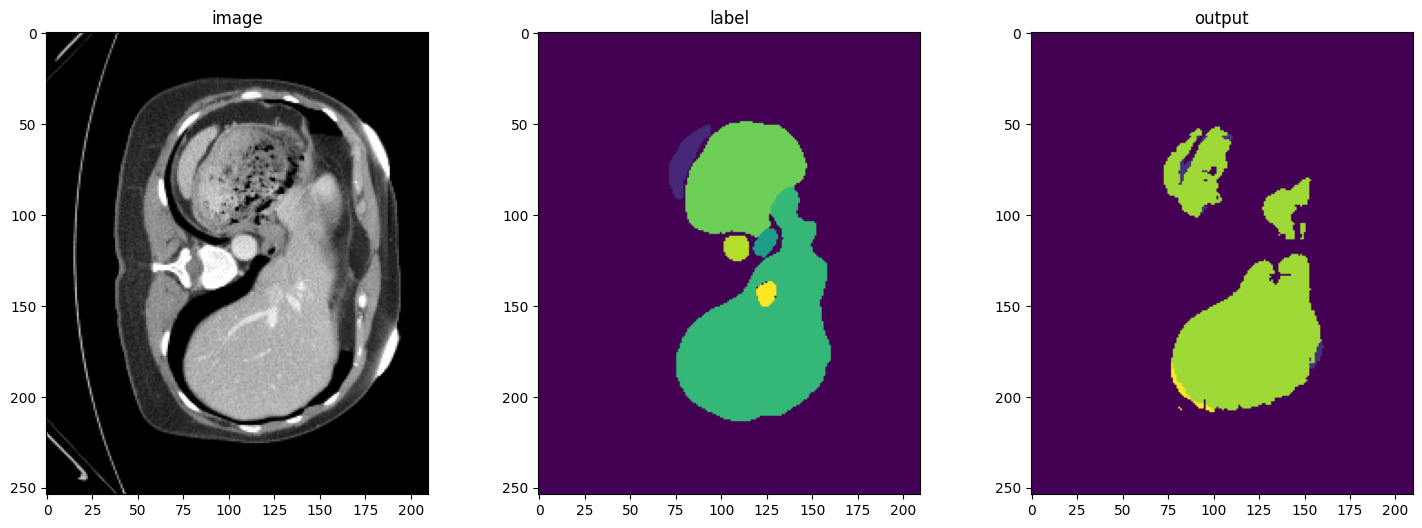

In [81]:
case_num = 4
k_model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, k_model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

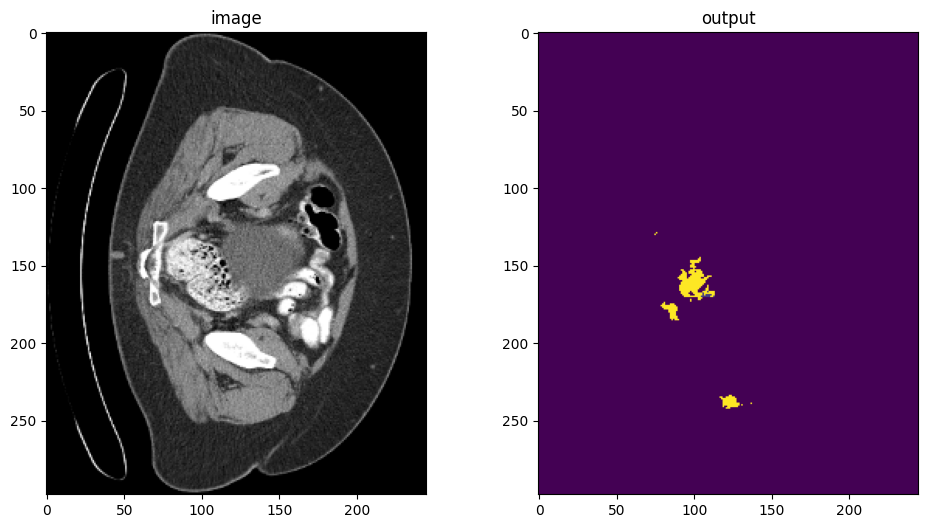

In [76]:
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(x.cpu().numpy()[0, :, :, 50], cmap="gray")
# plt.subplot(1, 3, 2)
# plt.title("label")
# plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
plt.subplot(1, 3, 2)
plt.title("output")
plt.imshow(torch.argmax(yhat, dim=1).detach().cpu()[0, :, :, 50])
plt.show()
